<a href="https://colab.research.google.com/github/tbonne/IntroDataScience/blob/main/fullNoteBooks/A_B_Testing_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='http://drive.google.com/uc?export=view&id=1JqHLLc4CGhWdmUAb0xCn1anYe6Qkl_U_' width=500>


# <font color='lightblue'>A/B Testing</font>

Here we will look at how to collect and analyze data to determine the difference between two groups. The idea here is that if we randomly assign individuals to two groups we end up with comparable groups. If we then measure how these two groups respond to a treatment (e.g., being given game version A vs. game version B) we can better determine the effect of that treatment. 


We'll take a look at data collected to test how effective different versions of a game are at retaining users. 




In [51]:
#load packages
import pandas as pd
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Load the data

In [52]:
#load data
df_cats = pd.read_csv("/content/cookie_cats.csv")

#take a look
df_cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### <font color='lightblue'>Describe the data</font>

How many in each group?

In [53]:
df_cats.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

How many users returned after 7 days?

In [54]:
#gate placed at level 30
df_cats[df_cats['version']=='gate_30'].retention_7.sum() / len(df_cats[df_cats['version']=='gate_30'])

0.19020134228187918

In [55]:
#gate placed at level 40
df_cats[df_cats['version']=='gate_40'].retention_7.sum() / len(df_cats[df_cats['version']=='gate_40'])

0.18200004396667327

### <font color='lightblue'>Visualize the data</font>

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

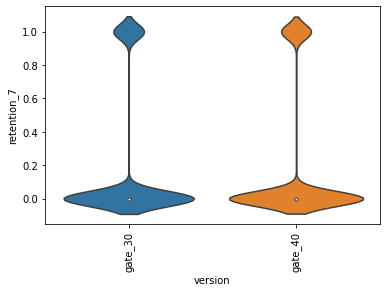

In [56]:
#plot difference between the versions
sns.violinplot(data=df_cats, x="version",y="retention_7")
plt.xticks(rotation=90)

### <font color='lightblue'>Wrangle the data</font>

Convert the binary traget and binary input variable to 0/1

In [57]:
from sklearn.preprocessing import OrdinalEncoder

#get the columns names of features you'd like to turn into 0/1
bin_names = ['retention_7','version']

#create a dataframe of those features
bin_features = df_cats[bin_names]

#fit the scaler to those data
bin_scaler = OrdinalEncoder().fit(bin_features.values)

#use the scaler to transform your data
bin_features = bin_scaler.transform(bin_features.values)

#put these scaled features back into your transformed features dataframe
df_cats[bin_names] = bin_features

#take a look
df_cats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,0.0,3,False,0.0
1,337,0.0,38,True,0.0
2,377,1.0,165,True,0.0
3,483,1.0,1,False,0.0
4,488,1.0,179,True,1.0
...,...,...,...,...,...
90184,9999441,1.0,97,True,0.0
90185,9999479,1.0,30,False,0.0
90186,9999710,0.0,28,True,0.0
90187,9999768,1.0,51,True,0.0


Check which version is assigned to which value

In [58]:
bin_scaler.categories_

[array([False, True], dtype=object),
 array(['gate_30', 'gate_40'], dtype=object)]

Split your data into training and testing

In [59]:
#split these data into training and testing datasets
df_train, df_test = train_test_split(df_cats, test_size=0.20, stratify=df_cats[['retention_7']])

## <font color='lightblue'>Build a model</font>

Can we predict which game version does better?

In [60]:
import statsmodels.api as sm #for running regression!
import statsmodels.formula.api as smf

#1. Build the model
linear_reg_model = smf.logit(formula='retention_7 ~ version  ', data=df_train)

#2. Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_results = linear_reg_model.fit()

#3. take a look at the summary
print(linear_reg_results.summary())

Optimization terminated successfully.
         Current function value: 0.480396
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            retention_7   No. Observations:                72151
Model:                          Logit   Df Residuals:                    72149
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:               0.0001568
Time:                        17:48:35   Log-Likelihood:                -34661.
converged:                       True   LL-Null:                       -34666.
Covariance Type:            nonrobust   LLR p-value:                 0.0009771
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4443      0.013   -107.391      0.000      -1.471      -1.418
version       -0.0631      0.

Make predictions to get the probability (i.e., in the table these are values on the logit scale!).

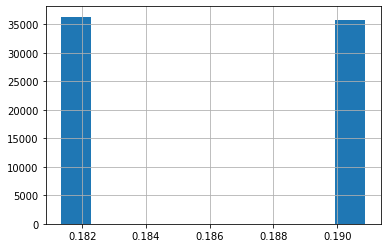

In [61]:
y_pred_prob = linear_reg_results.predict(df_train)
y_pred_prob.hist()

Run the model again but this time add in the sum of the times they played the game in the first 2 weeks.

In [62]:
import statsmodels.api as sm #for running regression!
import statsmodels.formula.api as smf

#1. Build the model
linear_reg_model = smf.logit(formula='retention_7 ~ version + sum_gamerounds  ', data=df_train)

#2. Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_results = linear_reg_model.fit()

#3. take a look at the summary
print(linear_reg_results.summary())

Optimization terminated successfully.
         Current function value: 0.331894
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            retention_7   No. Observations:                72151
Model:                          Logit   Df Residuals:                    72148
Method:                           MLE   Df Model:                            2
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                  0.3092
Time:                        17:48:36   Log-Likelihood:                -23946.
converged:                       True   LL-Null:                       -34666.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.6828      0.020   -132.356      0.000      -2.723      -2.643
version          

Calculate the difference in predicted probability

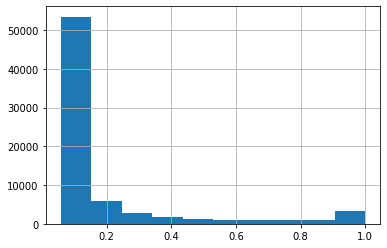

In [63]:
y_pred_prob = linear_reg_results.predict(df_train)
y_pred_prob.hist()

Check to make sure the pattern you found generalizes to the whitheld dataset. (i.e., are you overfitting)

Text(33.0, 0.5, 'True label')

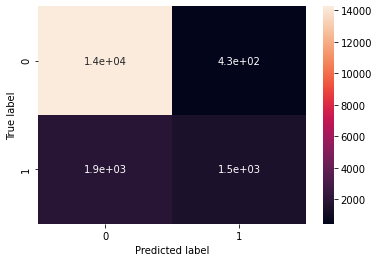

In [64]:
from sklearn.metrics import confusion_matrix

#predict on testing data
y_pred_prob = linear_reg_results.predict(df_test)

#convert probs to 0/1
y_pred = (y_pred_prob > 0.5).astype(int)

#create a confusion matrix
cm_logit = confusion_matrix(df_test.retention_7, y_pred)

#visualize the confusion matrix
sns.heatmap(cm_logit, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')

## <font color='lightblue'>Bonus</font>


What does the model think retetion will change when we vary versions and sum_gamerounds?

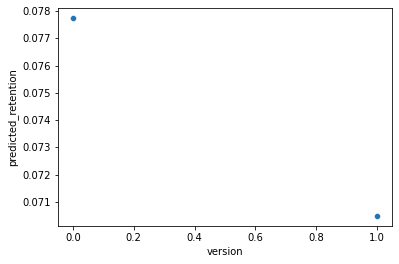

In [65]:
#1. Create a dataframe
df_question = pd.DataFrame({'version':[0,1],
                            'sum_gamerounds':10})
                            
#2. Use the model to make predictions
question_pred =  linear_reg_results.predict(df_question)

#3. add a column to the df_question
df_question['predicted_retention'] = question_pred

#4. plot the predictions
sns.scatterplot(data=df_question, x='version',y='predicted_retention')

Try to match those predictions based on your knowledge of the linear formula (y=a+bx)

In [66]:
import scipy

#the following function can be used to convert numbers on the logit scale back into the probability scale
scipy.special.expit(0)

#i.e., on the logit scale 0 is equivalent to 0.5 probability

0.5

In [67]:
#what was the intercept and slope of the line your model estimated?
intercept = -1.4523
b_version = -0.0802
b_sumGame = 0.0209

In [68]:
#probability of retention for version 0
scipy.special.expit(intercept + b_version * 0 + b_sumGame*100)

0.6542333575709954

In [69]:
#probability of retention for version 1
scipy.special.expit(intercept + b_version * 1 + b_sumGame*100)

0.6358738914270539